In [33]:
TRAIN = 0
REBUILD_DATA = 0
AD_TEST_ONLY = 0

DONT_LOAD_TRAIN = 1
SKIP_WHOLE_TESTINGSET_EVAL = 1

KINECT = 0

TRAIN_CSV = 'train8.csv'
TEST_CSV = 'test8.csv'
AD_TEST_CSV = 'test_additional2.csv'

MODEL_ARCH_FILE = 'model_5l_segmented_8classes.json'
MODEL_WEIGHTS = 'model_5l_weight_ep50_combined_poses_8classes.hdf5'
# MODEL_WEIGHTS = 'checkpoints/hand_segmented_segnet_model.00012-0.1781-0.9322-0.6017-0.8298.hdf5'
TRAINING_HIST = 'training_his_segmented_8classes.pickle'

train_data_path = 'train_data_segmented_8classes.npy'
train_label_path = 'train_label_segmented_8classes.npy'
test_data_path = 'test_data_segmented_8classes.npy'
test_label_path = 'test_label_segmented_8classes.npy'
ad_test_data_path = 'test_data_additional_segmented_8classes.npy'
ad_test_label_path = 'test_label_additional_segmented_8classes.npy'

path = ''
# img_w = 512
# img_w = 424
# img_w = 128
# img_h = 128
img_w = 96
img_h = 96
# img_w = 72
# img_h = 72
# img_w = 378
# img_h = 161

n_labels = 8

kernel = 3

n_train = 33900
if SKIP_WHOLE_TESTINGSET_EVAL == 1:
    n_test = 3500
else:
    n_test = 22600
n_ad_test = 0

#     n_train = 2
#     n_test = 2

# SegNet model implemented with keras

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from skimage.transform import resize
from skimage import color

from matplotlib import pyplot as plt

import os

from tensorflow.contrib.keras.python.keras import models
from tensorflow.contrib.keras.python.keras.optimizers import SGD, Adam
from tensorflow.contrib.keras.python.keras.models import model_from_json
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build model
from tensorflow.contrib.keras.python.keras.layers.core import Activation, Reshape, Permute, Flatten, Dense
from tensorflow.contrib.keras.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers import Dropout
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization

from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model

from tensorflow.contrib.keras.python.keras.models import load_model

import json

import pickle

from IPython.display import clear_output

import time

import cv2

# Kinect

In [3]:
from pykinect2 import PyKinectV2
from pykinect2.PyKinectV2 import *
from pykinect2 import PyKinectRuntime

import ctypes
import _ctypes
import pygame

if sys.hexversion >= 0x03000000:
    import _thread as thread
else:
    import thread
    
# colors for drawing different bodies 
SKELETON_COLORS = [pygame.color.THECOLORS["red"],
                    pygame.color.THECOLORS["blue"], 
                    pygame.color.THECOLORS["green"],
                    pygame.color.THECOLORS["orange"], 
                    pygame.color.THECOLORS["purple"], 
                    pygame.color.THECOLORS["yellow"], 
                    pygame.color.THECOLORS["violet"]]

### Utility functions

In [4]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(np.ceil(labels[r][c]))] = 1
    return np.uint8(label_map)
#     print(np.unique(label_map))
#     return label_map

In [5]:
def label_map_8_classes(gt2):
    label_map = np.zeros([img_h, img_w, n_labels])
    
#     print(np.unique(gt2))
    for color_chal in [0, 1, 2]:
        x = gt2[:, :, color_chal]
        x[x == 0] = 1
        x[x == 127] = 2
        x[x == 255] = 3
        gt2[:, :, color_chal] = x
        
    gt3 = gt2[:, :, 0] + 10*gt2[:, :, 1] + 100*gt2[:, :, 2]
#     print(np.unique(gt3))
    
#     gt3[gt3 == 77] = 0
    gt3[gt3 == 111] = 0      # co tay
    gt3[gt3 == 112] = 1      # ngon cai
    gt3[gt3 == 121] = 2      # ngon tro
    gt3[gt3 == 211] = 3      # ngon giua
    gt3[gt3 == 212] = 4      # ngon ke
    gt3[gt3 == 221] = 5      # ngon ut
    gt3[gt3 == 222] = 6      # long ban tay
    gt3[gt3 == 333] = 7      # nen
    
#     [[ 7.  7.  3.  7.  4.  7.  7.  7.  7.  7.]
#      [ 7.  7.  7.  3.  4.  7.  7.  7.  7.  7.]
#      [ 7.  2.  7.  3.  7.  4.  7.  5.  7.  7.]
#      [ 7.  2.  2.  3.  3.  4.  7.  5.  7.  7.]
#      [ 7.  7.  2.  6.  6.  6.  6.  6.  7.  7.]
#      [ 7.  7.  7.  6.  6.  6.  6.  6.  7.  7.]
#      [ 1.  1.  7.  6.  6.  6.  6.  6.  6.  7.]
#      [ 7.  7.  1.  6.  6.  6.  6.  6.  6.  7.]
#      [ 7.  7.  7.  7.  6.  6.  6.  6.  0.  0.]
#      [ 7.  7.  7.  7.  7.  7.  7.  7.  0.  0.]]
    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(gt3[r][c])] = 1
    
#     111.  112.  121.  211.  212.  221.  222.  333
    
#     print(np.unique(gt3))

    return np.uint8(label_map)
        
#     plt.imshow(gt3, cmap='gray')
#     plt.show()    
    
#     np.savetxt('asd.txt', gt3, fmt='%d')

In [6]:
def prep_data(mode):
#     n_train = 2
#     n_test = 2
    assert mode in {'test', 'train', 'ad_test'}, \
        'mode should be either \'test\' or \'train\' or \'ad_test\''
    data = []
    label = []
    if mode == 'train':
        df = pd.read_csv(path + TRAIN_CSV)
        n = n_train
    elif mode == 'test':
        df = pd.read_csv(path + TEST_CSV)
        n = n_test
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
        n = n_ad_test
        
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [resize(imread(path + item[0]), (img_h, img_w))], resize(imread(path + item[1]), (img_h, img_w), preserve_range=True, order=0)
        
        data.append(img)
        label.append(label_map_8_classes(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))
#     print(np.unique(data))
#     print(np.unique(label))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label


# def prep_data(mode):
# #     n_train = 2
# #     n_test = 2
#     assert mode in {'test', 'train', 'ad_test'}, \
#         'mode should be either \'test\' or \'train\' or \'ad_test\''
#     data = []
#     label = []
#     if mode == 'train':
#         df = pd.read_csv(path + TRAIN_CSV)
#         n = n_train
#     elif mode == 'test':
#         df = pd.read_csv(path + TEST_CSV)
#         n = n_test
#     else:
#         df = pd.read_csv(path + AD_TEST_CSV)
#         n = n_ad_test
        
#     for i, item in df.iterrows():
#         if i >= n:
#             break
#         img, gt = [resize(imread(path + item[0]), (img_h, img_w))], resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
        
#         data.append(img)
#         label.append(label_map(gt))
#         sys.stdout.write('\r')
#         sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
#                                                     int(100. * (i + 1) / n)))
#         sys.stdout.flush()
#     sys.stdout.write('\r')
#     sys.stdout.flush()
#     data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))
# #     print(np.unique(data))
# #     print(np.unique(label))

#     print(mode + ': OK')
#     print('\tshapes: {}, {}'.format(data.shape, label.shape))
#     print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
#     print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

#     return data, label

In [7]:
def get_rgb_from_class(pred_cls):
    if pred_cls == 0:
        return [0, 0, 0]
    elif pred_cls == 1:
        return [0, 0, 127]
    elif pred_cls == 2:
        return [0, 127, 0]
    elif pred_cls == 3:
        return [127, 0, 0]
    elif pred_cls == 4:
        return [127, 0, 127]
    elif pred_cls == 5:
        return [127, 127, 0]
    elif pred_cls == 6:
        return [127, 127, 127]
    elif pred_cls == 7:
        return [255, 255, 255]
    
def plot_results_2(output, indx):
    if AD_TEST_ONLY == 0:
        df = pd.read_csv(path + TEST_CSV)
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
    
    n_test_imgs = indx.shape[0]
    plt.figure(figsize=(7, 2 * n_test_imgs))
    
    subplot_indx = 0
    for cur_indx in indx:
        for i, item in df.iterrows():
            if i == cur_indx:
                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 1)
                plt.title('Input Image')
                plt.axis('off')
                im = resize(imread(path + item[0]), (img_h, img_w))
                plt.imshow(im, cmap='gray')

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 2)
                plt.title('Ground Truth')
                plt.axis('off')
                gt = resize(imread(path + item[1]), (img_h, img_w))
                plt.imshow(gt)

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 3)
                plt.title('Prediction')
                plt.axis('off')
                
                labeled = np.ones([img_h, img_w, 3]) * 255
                output = np.reshape(output, (5, img_h, img_w))
                
                for r in range(img_h):
                    for c in range(img_w):
                        re, gr, bl = get_rgb_from_class(output[subplot_indx, r, c])
                        labeled[r, c, 2] = re
                        labeled[r, c, 1] = gr
                        labeled[r, c, 0] = bl
                
                labeled = np.uint8(labeled)
                plt.imshow(labeled)

                subplot_indx += 1

                break

#     plt.savefig('result.png')
    plt.show()

In [8]:
# def plot_results_2(output, indx):
#     if AD_TEST_ONLY == 0:
#         df = pd.read_csv(path + TEST_CSV)
#     else:
#         df = pd.read_csv(path + AD_TEST_CSV)
    
#     n_test_imgs = indx.shape[0]
#     plt.figure(figsize=(15, 2 * n_test_imgs))
    
#     subplot_indx = 0
#     for cur_indx in indx:
#         for i, item in df.iterrows():
#             if i == cur_indx:
#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 1)
#                 plt.title('Input Image')
#                 plt.axis('off')
#                 im = resize(imread(path + item[0]), (img_h, img_w))
#                 plt.imshow(im, cmap='gray')

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 2)
#                 plt.title('Ground Truth')
#                 plt.axis('off')
#                 gt = resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
#                 plt.imshow(np.clip(gt, 0, 1), cmap='gray')

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 3)
#                 plt.title('Prediction')
#                 plt.axis('off')
#                 labeled = np.argmax(output[subplot_indx], axis=-1)
#                 plt.imshow(labeled, cmap='gray')

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 4)
#                 plt.title('Heat map')
#                 plt.axis('off')
#                 plt.imshow(output[subplot_indx][:, :, 1])

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 5)
#                 plt.title('Comparison')
#                 plt.axis('off')
#                 rgb = np.empty((img_h, img_w, 3))
#                 rgb[:, :, 0] = labeled
#                 img = resize(imread(path + item[0]), (img_h, img_w))
#                 rgb[:, :, 1] = img
#                 rgb[:, :, 2] = gt
#                 plt.imshow(rgb)

#                 subplot_indx += 1

#                 break

# #     plt.savefig('result.png')
#     plt.show()

### Build Model

In [9]:
# if os.path.isfile(MODEL_ARCH_FILE):
#     print('Loading model...', end='')
#     with open(MODEL_ARCH_FILE, 'r') as f:
#         json_string = f.read()
#     autoencoder = model_from_json(json_string)
#     print('done.')
# else:
print('Defining model...', end='')
encoding_layers = [
    Conv2D(64, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_labels, (1, 1), padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Reshape((n_labels, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))

with open(MODEL_ARCH_FILE, 'w') as outfile:
    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))

print('done.')

print('Compiling model...', end='')
# optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
optimizer = Adam(lr=0.001, decay=0.0005)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print('done.')

print(autoencoder.summary())

Defining model...done.
Compiling model...done.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 

### Data

In [10]:
if 'train_data' in globals():
    del train_data
if 'train_label' in globals():
    del train_label
if 'test_data' in globals():
    del test_data
if 'test_label' in globals():
    del test_label

if 'data' in locals():
    del data
if 'label' in locals():
    del label

In [11]:
# n_train = 24500
# n_test = 10500
# n_ad_test = 21500

# n_train = 2
# n_test = 2

if AD_TEST_ONLY == 0:
    if KINECT == 0:
        if DONT_LOAD_TRAIN == 0:
            if os.path.isfile(train_data_path) and os.path.isfile(train_label_path) and REBUILD_DATA == 0:
                print('Loading training data...', end='')
                train_data = np.load(train_data_path)
                train_label = np.load(train_label_path)
                print('done.')
            else:
                train_data, train_label = prep_data('train')
                np.save(train_data_path, train_data)
                np.save(train_label_path, train_label)

    if SKIP_WHOLE_TESTINGSET_EVAL == 0:
        if os.path.isfile(test_data_path) and os.path.isfile(test_label_path) and REBUILD_DATA == 0:
            print('Loading testing data...', end='')
            test_data = np.load(test_data_path)
            test_label = np.load(test_label_path)
            print('done.')
        else:
            test_data, test_label = prep_data('test')
            np.save(test_data_path, test_data)
            np.save(test_label_path, test_label)
else:
    if os.path.isfile(ad_test_data_path) and os.path.isfile(ad_test_label_path):
        print('Loading additional testing data...', end='')
        test_data = np.load(ad_test_data_path)
        test_label = np.load(ad_test_label_path)
        print('done.')
    else:
        test_data, test_label = prep_data('ad_test')
        np.save(ad_test_data_path, test_data)
        np.save(ad_test_label_path, test_label)

In [12]:
# for c_indx in [0, 1, 2, 3, 4, 5, 6, 7]:
#     print(np.unique(train_label[:, :, c_indx]))
#     print(np.unique(train_label[:, :, c_indx]))

### Train model or load existing weights

In [18]:
if TRAIN == 1 and AD_TEST_ONLY == 0 and KINECT == 0:
    start_time = time.time()
    
    nb_epoch = 100
    batch_size = 8

    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
    checkpointer = ModelCheckpoint(monitor='val_acc', filepath='checkpoints/hand_segmented_segnet_model.{epoch:05d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5', verbose=1, save_best_only=True)

    history = autoencoder.fit(train_data, train_label,
                              batch_size=batch_size, epochs=nb_epoch,
                              verbose=1,
                              validation_data=(test_data, test_label),
                              callbacks=[checkpointer, early_stopping])
    
    training_time = time.time() - start_time
    print('> Training time on GTX1080: ' + str(training_time) + ' sec')

    # Save trained model
    autoencoder.save_weights(MODEL_WEIGHTS)
    
    # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(history.history, f)
        
    history_ = history.history
else:
    if SKIP_WHOLE_TESTINGSET_EVAL == 0:
        print('Loading trained weights...', end='')
        # Load trained model
        autoencoder.load_weights(MODEL_WEIGHTS)
        print('done.')
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)

In [19]:
# Train on 33900 samples, validate on 22600 samples
# Epoch 1/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.6328 - acc: 0.7751Epoch 00000: val_acc improved from -inf to 0.76987, saving model to checkpoints/hand_segmented_segnet_model.00000-0.6328-0.7751-0.6449-0.7699.hdf5
# 33900/33900 [==============================] - 873s - loss: 0.6328 - acc: 0.7751 - val_loss: 0.6449 - val_acc: 0.7699
# Epoch 2/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.3793 - acc: 0.8550Epoch 00001: val_acc improved from 0.76987 to 0.79689, saving model to checkpoints/hand_segmented_segnet_model.00001-0.3793-0.8550-0.5778-0.7969.hdf5
# 33900/33900 [==============================] - 844s - loss: 0.3793 - acc: 0.8550 - val_loss: 0.5778 - val_acc: 0.7969
# Epoch 3/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.3041 - acc: 0.8831Epoch 00002: val_acc improved from 0.79689 to 0.80977, saving model to checkpoints/hand_segmented_segnet_model.00002-0.3041-0.8831-0.5559-0.8098.hdf5
# 33900/33900 [==============================] - 844s - loss: 0.3041 - acc: 0.8831 - val_loss: 0.5559 - val_acc: 0.8098
# Epoch 4/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.2661 - acc: 0.8978Epoch 00003: val_acc improved from 0.80977 to 0.81467, saving model to checkpoints/hand_segmented_segnet_model.00003-0.2661-0.8978-0.5686-0.8147.hdf5
# 33900/33900 [==============================] - 844s - loss: 0.2661 - acc: 0.8978 - val_loss: 0.5686 - val_acc: 0.8147
# Epoch 5/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.2426 - acc: 0.9070Epoch 00004: val_acc improved from 0.81467 to 0.81606, saving model to checkpoints/hand_segmented_segnet_model.00004-0.2426-0.9070-0.5781-0.8161.hdf5
# 33900/33900 [==============================] - 843s - loss: 0.2426 - acc: 0.9070 - val_loss: 0.5781 - val_acc: 0.8161
# Epoch 6/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.2260 - acc: 0.9135Epoch 00005: val_acc improved from 0.81606 to 0.82362, saving model to checkpoints/hand_segmented_segnet_model.00005-0.2260-0.9135-0.5645-0.8236.hdf5
# 33900/33900 [==============================] - 835s - loss: 0.2260 - acc: 0.9135 - val_loss: 0.5645 - val_acc: 0.8236
# Epoch 7/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.2144 - acc: 0.9180Epoch 00006: val_acc did not improve
# 33900/33900 [==============================] - 839s - loss: 0.2144 - acc: 0.9180 - val_loss: 0.5778 - val_acc: 0.8223
# Epoch 8/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.2053 - acc: 0.9216Epoch 00007: val_acc improved from 0.82362 to 0.82625, saving model to checkpoints/hand_segmented_segnet_model.00007-0.2053-0.9216-0.5708-0.8263.hdf5
# 33900/33900 [==============================] - 843s - loss: 0.2053 - acc: 0.9216 - val_loss: 0.5708 - val_acc: 0.8263
# Epoch 9/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.1975 - acc: 0.9246Epoch 00008: val_acc improved from 0.82625 to 0.82663, saving model to checkpoints/hand_segmented_segnet_model.00008-0.1975-0.9246-0.5756-0.8266.hdf5
# 33900/33900 [==============================] - 845s - loss: 0.1975 - acc: 0.9246 - val_loss: 0.5756 - val_acc: 0.8266
# Epoch 10/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.1916 - acc: 0.9269Epoch 00009: val_acc improved from 0.82663 to 0.82681, saving model to checkpoints/hand_segmented_segnet_model.00009-0.1916-0.9269-0.5871-0.8268.hdf5
# 33900/33900 [==============================] - 843s - loss: 0.1916 - acc: 0.9269 - val_loss: 0.5871 - val_acc: 0.8268
# Epoch 11/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.1864 - acc: 0.9290Epoch 00010: val_acc improved from 0.82681 to 0.82838, saving model to checkpoints/hand_segmented_segnet_model.00010-0.1864-0.9290-0.5935-0.8284.hdf5
# 33900/33900 [==============================] - 844s - loss: 0.1864 - acc: 0.9290 - val_loss: 0.5935 - val_acc: 0.8284
# Epoch 12/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.1820 - acc: 0.9307Epoch 00011: val_acc improved from 0.82838 to 0.82911, saving model to checkpoints/hand_segmented_segnet_model.00011-0.1820-0.9307-0.5958-0.8291.hdf5
# 33900/33900 [==============================] - 861s - loss: 0.1820 - acc: 0.9307 - val_loss: 0.5958 - val_acc: 0.8291
# Epoch 13/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.1780 - acc: 0.9322Epoch 00012: val_acc improved from 0.82911 to 0.82976, saving model to checkpoints/hand_segmented_segnet_model.00012-0.1781-0.9322-0.6017-0.8298.hdf5
# 33900/33900 [==============================] - 856s - loss: 0.1781 - acc: 0.9322 - val_loss: 0.6017 - val_acc: 0.8298
# Epoch 14/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.1747 - acc: 0.9335Epoch 00013: val_acc did not improve
# 33900/33900 [==============================] - 841s - loss: 0.1747 - acc: 0.9335 - val_loss: 0.6069 - val_acc: 0.8296
# Epoch 00013: early stopping
# > Training time on GTX1080: 11876.143295049667 sec
# In [ ]:


# Training summary

In [20]:
print('Loading trained weights...', end='')
# Load trained model
MODEL_WEIGHTS = 'checkpoints/hand_segmented_segnet_model.00012-0.1781-0.9322-0.6017-0.8298.hdf5'
# MODEL_WEIGHTS = 'model_5l_weight_ep50_combined_poses_8classes.hdf5'
autoencoder.load_weights(MODEL_WEIGHTS)
# autoencoder = load_model(MODEL_WEIGHTS)
print('done.')

Loading trained weights...done.


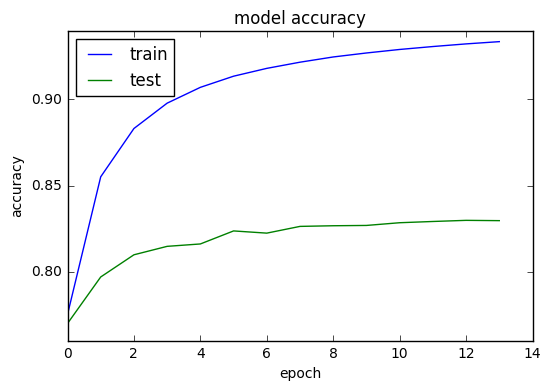

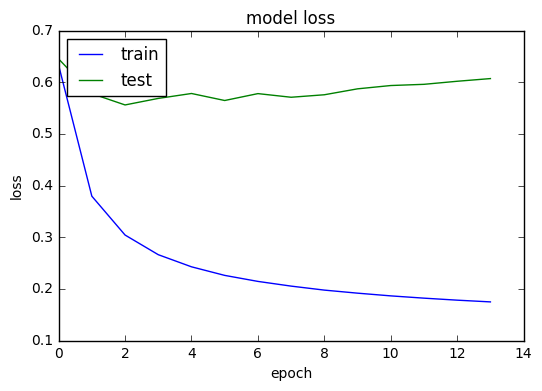

In [21]:
if KINECT == 0:
    # list all data in history
#     print(history_.keys())
    # summarize history for accuracy
    plt.plot(history_['acc'])
    plt.plot(history_['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history_['loss'])
    plt.plot(history_['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Model visualization

In [17]:
# plot_model(autoencoder, to_file='model.png', show_shapes=True)

### Load testing data and evaluate score

In [22]:
if SKIP_WHOLE_TESTINGSET_EVAL == 0:
    # if KINECT == 0:
    score = autoencoder.evaluate(test_data, test_label, verbose=1)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    # score = autoencoder.evaluate(train_data, train_label, verbose=0)
    # print('Train score:', score[0])
    # print('Train accuracy:', score[1])

# 1. Classification accuracy for the whole testingset

In [23]:
def avg_acc(pred, gt):
    aa = np.zeros((1, 7))
    cot = np.zeros((1, 7))
    for y in range(0, img_h):
        for x in range(0, img_w):
            # Not the backgrond
            if gt[y, x] != 7:
                cot[0, gt[y, x]] += 1
                if gt[y, x] == pred[y, x]:
                    aa[0, gt[y, x]] += 1
    for i in range(7):
        if cot[0, i] == 0:
            cot[0, i] = 1
    aa = aa/cot
    return [np.sum(aa)/7, aa]

In [24]:
# 1. calc output for ALL testing items
# 2. estimate avg_acc for ALL testing items

# 3. count number of testing items whose avg_acc is greater than epsilon

In [25]:
if SKIP_WHOLE_TESTINGSET_EVAL == 0:
    # 1.1 calc output for ALL testing items
    clear_output(wait=True)
    print('> 1.1 calculating output for ALL testing items...')
    output = autoencoder.predict_classes(test_data, verbose=1)
    output = np.reshape(output, (-1, img_h, img_w))
    print('done.')

In [26]:
if SKIP_WHOLE_TESTINGSET_EVAL == 0:
    # 1.2 prepare truth labels
    clear_output(wait=True)
    print('> 1.2 preparing truth labels...')
    test_lab = np.reshape(test_label, (-1, img_h, img_w, 8))
    test_lab = np.argmax(test_lab, axis=3)
    print('done.')

In [27]:
if SKIP_WHOLE_TESTINGSET_EVAL == 0:
    # 2. estimate avg_acc for ALL testing items
    n_testing_items = len(test_data)
    avg_acc_testing = np.zeros((len(test_data), 1))
    for testing_indx in range(n_testing_items):
        if testing_indx % 200 == 0:
            clear_output(wait=True)
            print('> 2. estimating avg_acc for ALL testing items... (%d/%d)' % (testing_indx + 1, n_testing_items))
        cur_output = output[testing_indx, :, :]
        cur_test_lab = test_lab[testing_indx, :, :]
        aa = avg_acc(cur_output, cur_test_lab)

        avg_acc_testing[testing_indx, 0] = aa[0]

    print('done.')

### Modify accuracy threshold here!

In [28]:
if SKIP_WHOLE_TESTINGSET_EVAL == 0:
    acc_threshold_int_range = range(0, 101, 1)
    acc_threshold_fl = np.zeros((len(acc_threshold_int_range), 1))

    thre_indx = 0
    for acc_threshold_int in acc_threshold_int_range:
        acc_threshold_fl[thre_indx] = float(acc_threshold_int)/100
        thre_indx += 1

In [29]:
if SKIP_WHOLE_TESTINGSET_EVAL == 0:
    n_selected_items_testing = np.zeros(acc_threshold_fl.shape)
    rate_items_testing = np.zeros(acc_threshold_fl.shape)

    sel_indx = 0
    for acc_threshold in acc_threshold_fl:
        n_selected_items = 0
        for testing_indx in range(n_testing_items):
            if avg_acc_testing[testing_indx] > acc_threshold:
                n_selected_items += 1

        n_selected_items_testing[sel_indx, 0] = n_selected_items
        rate_items_testing[sel_indx, 0] = float(n_selected_items)/n_testing_items
        sel_indx += 1

In [30]:
if SKIP_WHOLE_TESTINGSET_EVAL == 0:
    # for ind in range(len(n_selected_items_testing)):
    #     print('epsilon = %f, # accepted items = %d/%d = %f' % (acc_threshold_fl[ind], n_selected_items_testing[ind], n_testing_items, rate_items_testing[ind]))

    plt.plot(acc_threshold_fl, rate_items_testing, 'r', linewidth=4.0)
    plt.xlabel('Classification accuracy threshold epsilon')
    plt.ylabel('Proportion of frames with\naverage classification accuracy > epsilon')
    plt.show()

# 2. Classification accuracy for each subject

In [35]:
# 1. calc output for ALL testing items
# 2. estimate avg_acc for ALL testing items

# 3. count number of testing items whose avg_acc is greater than epsilon
def eval_subset(test_data, test_label):
    # 1.1 calc output for ALL testing items
#     clear_output(wait=True)
    print('> 1.1 calculating output for ALL testing items...')
    output = autoencoder.predict_classes(test_data, verbose=1)
    output = np.reshape(output, (-1, img_h, img_w))
    
    # 1.2 prepare truth labels
#     clear_output(wait=True)
    print('> 1.2 preparing truth labels...')
    test_lab = np.reshape(test_label, (-1, img_h, img_w, 8))
    test_lab = np.argmax(test_lab, axis=3)
    
    # 2. estimate avg_acc for ALL testing items
    n_testing_items = len(test_data)
    avg_acc_testing = np.zeros((len(test_data), 1))
    for testing_indx in range(n_testing_items):
        if testing_indx % 1000 == 0:
#             clear_output(wait=True)
            print('> 2. estimating avg_acc for ALL testing items... (%d/%d)' % (testing_indx + 1, n_testing_items))
        cur_output = output[testing_indx, :, :]
        cur_test_lab = test_lab[testing_indx, :, :]
        aa = avg_acc(cur_output, cur_test_lab)

        avg_acc_testing[testing_indx, 0] = aa[0]
    
    # Acc threshold
    acc_threshold_int_range = range(0, 101, 1)
    acc_threshold_fl = np.zeros((len(acc_threshold_int_range), 1))

    thre_indx = 0
    for acc_threshold_int in acc_threshold_int_range:
        acc_threshold_fl[thre_indx] = float(acc_threshold_int)/100
        thre_indx += 1
        
    n_selected_items_testing = np.zeros(acc_threshold_fl.shape)
    rate_items_testing = np.zeros(acc_threshold_fl.shape)

    sel_indx = 0
    for acc_threshold in acc_threshold_fl:
        n_selected_items = 0
        for testing_indx in range(n_testing_items):
            if avg_acc_testing[testing_indx] > acc_threshold:
                n_selected_items += 1

        n_selected_items_testing[sel_indx, 0] = n_selected_items
        rate_items_testing[sel_indx, 0] = float(n_selected_items)/n_testing_items
        sel_indx += 1
        
    return acc_threshold_fl, rate_items_testing

> processing combined_SubjectD.csv...
test: OK==================>] 100%
	shapes: (3500, 96, 96, 1), (3500, 9216, 8)
	types:  float64, uint8
	memory: 246.09375, 246.09375 MB
> 1.1 calculating output for ALL testing items...
3488/3500 [============================>.] - ETA: 0s> 1.2 preparing truth labels...
> 2. estimating avg_acc for ALL testing items... (1/3500)
> 2. estimating avg_acc for ALL testing items... (1001/3500)
> 2. estimating avg_acc for ALL testing items... (2001/3500)
> 2. estimating avg_acc for ALL testing items... (3001/3500)
> processing global_SubjectD.csv...
test: OK==================>] 100%
	shapes: (3500, 96, 96, 1), (3500, 9216, 8)
	types:  float64, uint8
	memory: 246.09375, 246.09375 MB
> 1.1 calculating output for ALL testing items...
3500/3500 [==============================] - 11s    
> 1.2 preparing truth labels...
> 2. estimating avg_acc for ALL testing items... (1/3500)
> 2. estimating avg_acc for ALL testing items... (1001/3500)
> 2. estimating avg_acc for

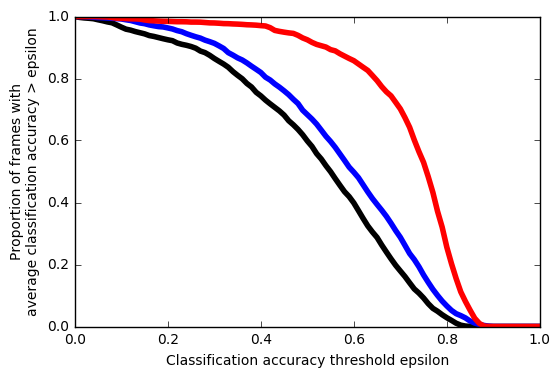

> processing combined_SubjectE.csv...
test: OK==================>] 100%
	shapes: (3500, 96, 96, 1), (3500, 9216, 8)
	types:  float64, uint8
	memory: 246.09375, 246.09375 MB
> 1.1 calculating output for ALL testing items...
3500/3500 [==============================] - 11s    
> 1.2 preparing truth labels...
> 2. estimating avg_acc for ALL testing items... (1/3500)
> 2. estimating avg_acc for ALL testing items... (1001/3500)
> 2. estimating avg_acc for ALL testing items... (2001/3500)
> 2. estimating avg_acc for ALL testing items... (3001/3500)
> processing global_SubjectE.csv...
test: OK==================>] 100%
	shapes: (3500, 96, 96, 1), (3500, 9216, 8)
	types:  float64, uint8
	memory: 246.09375, 246.09375 MB
> 1.1 calculating output for ALL testing items...
3500/3500 [==============================] - 11s    
> 1.2 preparing truth labels...
> 2. estimating avg_acc for ALL testing items... (1/3500)
> 2. estimating avg_acc for ALL testing items... (1001/3500)
> 2. estimating avg_acc fo

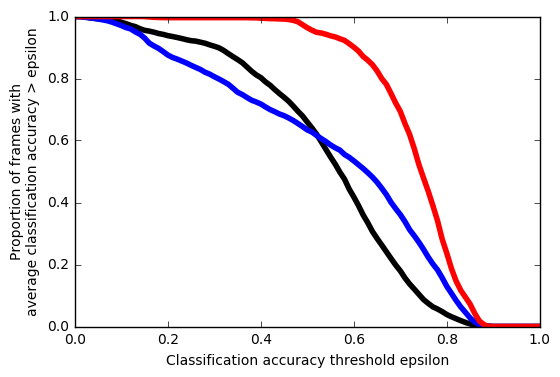

In [38]:
if SKIP_WHOLE_TESTINGSET_EVAL == 1:
    plt_color = ['k', 'b', 'r']
    data_type = ['combined', 'global', 'poses']
    subject_name = ['SubjectD', 'SubjectE']
    

    sn_indx = 0
    for sn in subject_name:
        plt.figure(sn_indx)
        dt_indx = 0
        for dt in data_type:
            # Load data
            TEST_CSV = dt + '_' + sn + '.csv'
            print('> processing %s...' % (TEST_CSV))
            test_data, test_label = prep_data('test')
            
            # Evaluate
            acc_threshold_fl, rate_items_testing = eval_subset(test_data, test_label)
    
            np.save('rate/' + dt + '_' + sn + '_rate_items_testing' + '.npy', rate_items_testing)
            np.save('rate/' + dt + '_' + sn + '_acc_threshold_fl' + '.npy', acc_threshold_fl)
        
            plt.plot(acc_threshold_fl, rate_items_testing, plt_color[dt_indx], linewidth=4.0)
            plt.xlabel('Classification accuracy threshold epsilon')
            plt.ylabel('Proportion of frames with\naverage classification accuracy > epsilon')
            dt_indx += 1
        plt.show()
        sn_indx += 1

In [41]:
# Save txt for excel
if SKIP_WHOLE_TESTINGSET_EVAL == 1:
    data_type = ['combined', 'global', 'poses']
    subject_name = ['SubjectD', 'SubjectE']
    

    for sn in subject_name:
        for dt in data_type:
            rate_items_testing = np.load('rate/' + dt + '_' + sn + '_rate_items_testing' + '.npy')
            acc_threshold_fl = np.load('rate/' + dt + '_' + sn + '_acc_threshold_fl' + '.npy')
    
            np.savetxt('rate/' + dt + '_' + sn + '_rate_items_testing' + '.txt', rate_items_testing, fmt='%.6f')
            np.savetxt('rate/' + dt + '_' + sn + '_acc_threshold_fl' + '.txt', acc_threshold_fl, fmt='%.2f')

In [ ]:
# def count_items_with_avg_acc_above(acc_threshold):
#     # 1.1 calc output for ALL testing items
#     clear_output(wait=True)
#     print('> 1.1 calculating output for ALL testing items...')
#     output = autoencoder.predict_classes(test_data, verbose=1)
#     output = np.reshape(output, (-1, img_h, img_w))
#     # 1.2 prepare truth labels
#     clear_output(wait=True)
#     print('> 1.2 preparing truth labels...')
#     test_lab = np.reshape(test_label, (-1, img_h, img_w, 8))
#     test_lab = np.argmax(test_lab, axis=3)
    
#     # 2. estimate avg_acc for ALL testing items
#     n_testing_items = len(test_data)
#     n_selected_items = 0
#     for testing_indx in range(n_testing_items):
#         if testing_indx % 10 == 0:
#             clear_output(wait=True)
#             print('> 2. estimating avg_acc for ALL testing items... (%d/%d)' % (testing_indx + 1, n_testing_items))
#             cur_output = output[testing_indx, :, :]
#             cur_test_lab = test_lab[testing_indx, :, :]
#             aa = avg_acc(cur_output, cur_test_lab)
            
#             if aa[0] > acc_threshold:
#                 n_selected_items += 1
#     return n_selected_items

In [ ]:
# print(count_items_with_avg_acc_above(0))

In [ ]:
# # np.set_printoptions(threshold=2000)
# # if KINECT == 0:
# testing_indx = np.random.choice(n_test, 1)
# # testing_indx = [11180]
# # testing_indx = [12153]

# aa, output, test_lab = avg_acc_of_index(testing_indx)

# print(np.transpose(aa[1]))
# print('avg acc = ' + str(aa[0]))
# # 0: co tay
# # 1: ngon cai
# # 2: ngon tro
# # 3: ngon giua
# # 4: ngon ke
# # 5: ngon ut
# # 6: long ban tay
# # 7: nen

# plt.imshow(output)
# plt.title('prediction')
# plt.show()
# plt.imshow(test_lab)
# plt.title('ground truth')
# plt.show()

### Visualizing results

In [ ]:
# if KINECT == 0:
testing_indx = np.random.choice(n_test, 5)

test_ite = test_data[testing_indx, :, :, :]
# test_ite = np.expand_dims(test_ite, axis=0)

# output = autoencoder.predict_proba(test_ite, verbose=1)
output = autoencoder.predict_classes(test_ite, verbose=1)

plot_results_2(output, testing_indx)

In [ ]:
# test_ite_ = test_ite[0, :, :, 0]
# # test_ite_ = np.rot90(test_ite_, -1)

# # cv2.imshow('depth', test_ite_)

# frame8bit = test_ite_
# # frame8bit = np.flip(frame8bit, 0)
# # frame8bit = np.rot90(frame8bit, -1)
# print(frame8bit)

# cv2.imshow('original image', frame8bit)
# print(frame8bit.shape)

# frame8bit_for_autoencoder = np.resize(frame8bit, (1, 128, 128, 1))

# output = autoencoder.predict_proba(frame8bit_for_autoencoder, verbose=0)
# output = output.reshape((output.shape[0], img_h, img_w, n_labels))

# frame8bit = resize(frame8bit[:, :], (img_h, img_w))

# rgb = np.zeros((img_h, 2*img_w, 3))
# labeled = np.argmax(output[0], axis=-1)

# rgb[:, :img_w, 0] = frame8bit
# rgb[:, :img_w, 1] = frame8bit
# rgb[:, :img_w, 2] = frame8bit

# rgb[:, img_w:, 0] = labeled

# #             rgb = cv2.resize(rgb, (2*256, 213))
# # #             rgb = cv2.resize(rgb, (512, 424))

# pred_time = time.time() - start_time
# print('FPS: ' + str(int(1.0/pred_time)))

# cv2.imshow('hand segmentation', rgb)


# k = cv2.waitKey(0) & 0xff
# if k == 27:     # Esc
#     cv2.destroyAllWindows()

In [ ]:
# cv2.destroyAllWindows()

# Realtime visualization

In [ ]:
# if KINECT == 0:
#     # test_data, test_label = prep_data('test')

#     if AD_TEST_ONLY == 0:
#         df = pd.read_csv(path + TEST_CSV)
#     else:
#         df = pd.read_csv(path + AD_TEST_CSV)

#     n_test_imgs = 1
#     n_type_outputs = 3

#     for i, item in df.iterrows():
#         clear_output(wait=True)

#         # Call trained model
#         test_ite = test_data[i, :, :, :]
#         test_ite = np.expand_dims(test_ite, axis=0)
#         print(test_ite.shape)
#         start_time = time.time()
#         output = autoencoder.predict_proba(test_ite, verbose=0)
#         pred_time = time.time() - start_time
#         output = output.reshape((output.shape[0], img_h, img_w, n_labels))

#         # Load input image
#         im = resize(imread(path + item[0]), (img_h, img_w))

#         # Load ground truth
#         gt = np.ceil(resize(~(imread(path + item[1])[:, :, 0]), (img_h, img_w))).astype(int)

#     #     rgb = np.empty((img_h, img_w, 3))
#         rgb = np.empty((img_h, 3*img_w, 3))
#         labeled = np.argmax(output[0], axis=-1)
#         img = resize(imread(path + item[0]), (img_h, img_w))
#         rgb[:, :img_w, 0] = img
#         rgb[:, :img_w, 1] = img
#         rgb[:, :img_w, 2] = img

#         rgb[:, img_w:2*img_w, 0] = img
#         rgb[:, img_w:2*img_w, 1] = img
#         rgb[:, img_w:2*img_w, 2] = img + gt

#         rgb[:, 2*img_w:, 0] = img
#         rgb[:, 2*img_w:, 1] = img + labeled
#         rgb[:, 2*img_w:, 2] = img

#         rgb = cv2.resize(rgb, (3*256, 213))

#         cv2.imshow('hand segmentation', rgb)
#         print('FPS: ' + str(int(1.0/pred_time)))

#         k = cv2.waitKey(30) & 0xff
#         if k == 27:     # Esc
#             cv2.destroyAllWindows()
#             break

# Kinect Hand Segmentation

In [ ]:
# cv2.destroyAllWindows()
# kinect.close()

In [ ]:
# if KINECT == 1:
#     kinect = PyKinectRuntime.PyKinectRuntime(PyKinectV2.FrameSourceTypes_Depth)
    
#     for dir_path, dir_names, file_names in os.walk('E:/fingerpaint_dataset_segnet/data/depth/combinedSubjectA_depth'):
#         for file_name in [f for f in file_names if f.endswith('.png')]:
#             depth_img = os.path.join(dir_path, file_name).replace("\\","/")
            
# #     while True:
# #         if kinect.has_new_depth_frame():
#             clear_output(wait=True)
            
#             start_time = time.time()
            
#             # Getting frames
#             frame = kinect.get_last_color_frame()
# #             frame = kinect.get_last_depth_frame()

#             # Displaying frames
#             # if frame is None:  # some usb hub do not provide the depth image. it works with Kinect studio though
#             #     return
            
# #             print(frame)
#             f8=np.uint8(frame.clip(1,1000)/16.)
# #             f8=np.uint8(frame.clip(1,4000)/16.)
# #             frame8bit_ = frame8bit
# #             frame8bit = np.dstack((frame8bit_, frame8bit_, frame8bit_))
#             frame8bit = np.dstack((f8,f8,f8))
#             frame8bit = np.reshape(frame8bit, (kinect.depth_frame_desc.Height, kinect.depth_frame_desc.Width, 3))
#             frame8bit = frame8bit[:, :, 0]
            
#             frame8bit = imread(depth_img)
            
#             frame8bit = resize(frame8bit, (img_h, img_w))
            
#             frame8bit_for_autoencoder = np.rot90(frame8bit)
#             frame8bit_for_autoencoder = np.flip(frame8bit_for_autoencoder, 0)
            
#             frame8bit_for_autoencoder = np.resize(frame8bit_for_autoencoder, (1, 128, 128, 1))
            
#             output = autoencoder.predict_proba(frame8bit_for_autoencoder, verbose=0)
#             output = output.reshape((output.shape[0], img_h, img_w, n_labels))

#             rgb = np.zeros((img_h, 2*img_w, 3))
#             labeled = np.argmax(output[0], axis=-1)
            
#             rgb[:, :img_w, 0] = frame8bit
#             rgb[:, :img_w, 1] = frame8bit
#             rgb[:, :img_w, 2] = frame8bit
            
#             rgb[:, img_w:, 0] = frame8bit
#             rgb[:, img_w:, 1] = frame8bit + labeled
#             rgb[:, img_w:, 2] = frame8bit

#             rgb = cv2.resize(rgb, (2*256, 213))
# # #             rgb = cv2.resize(rgb, (512, 424))
            
#             pred_time = time.time() - start_time
#             print('FPS: ' + str(int(1.0/pred_time)))
            
#             cv2.imshow('hand segmentation', rgb)

#             k = cv2.waitKey(30) & 0xff
#             if k == 27:     # Esc
#                 # Releasing frames
#                 frame = None
#                 cv2.destroyAllWindows()
#                 kinect.close()
#                 break